# tutorial

* https://huggingface.co/blog/time-series-transformers

# gluon examples

In [1]:
from datasets import load_dataset
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

dataset = load_dataset("monash_tsf", "tourism_monthly")
dataset


Using the latest cached version of the module from C:\Users\73915\.cache\huggingface\modules\datasets_modules\datasets\monash_tsf\fc869f3ae1577c9def2a919ab1dd0c3d4a7a44826b8e0e8fa423bb0161b629e2 (last modified on Thu Jul 13 17:23:04 2023) since it couldn't be found locally at monash_tsf., or remotely on the Hugging Face Hub.
Found cached dataset monash_tsf (C:/Users/73915/.cache/huggingface/datasets/monash_tsf/tourism_monthly/1.0.0/fc869f3ae1577c9def2a919ab1dd0c3d4a7a44826b8e0e8fa423bb0161b629e2)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})

In [2]:
train_example = dataset['train'][0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [3]:
validation_example = dataset['validation'][0]
print(validation_example['start'])
print(validation_example['target'])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

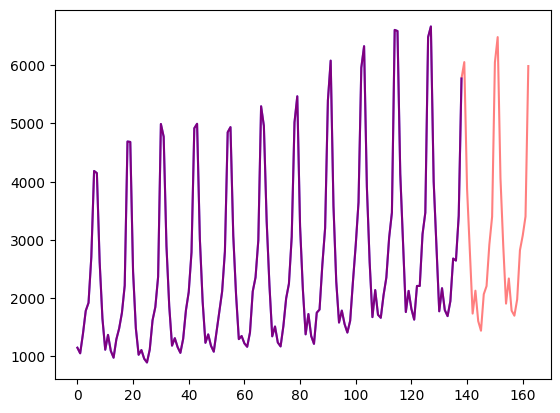

In [4]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue")
axes.plot(validation_example["target"], color="red", alpha=0.5)

plt.show()

In [5]:
freq = "1M"
prediction_length = 24

assert len(train_example["target"]) + prediction_length == len(
    validation_example["target"]
)

In [6]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [7]:
from functools import lru_cache

import pandas as pd
import numpy as np


def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [8]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [9]:
train_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 366
})

In [10]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


In [11]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function month_of_year at 0x0000015270CF1E50>]


In [12]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

In [13]:
model.config.distribution_output

'student_t'

In [14]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [15]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [16]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )


In [17]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )
    
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )


def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [18]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [19]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

# past_time_features torch.Size([256, 85, 2]) torch.FloatTensor 
# past_values torch.Size([256, 85]) torch.FloatTensor
# past_observed_mask torch.Size([256, 85]) torch.FloatTensor
# future_time_features torch.Size([256, 24, 2]) torch.FloatTensor
# static_categorical_features torch.Size([256, 1]) torch.IntTensor
# future_values torch.Size([256, 24]) torch.FloatTensor
# future_observed_mask torch.Size([256, 24]) torch.FloatTensor

past_time_features torch.Size([256, 85, 2]) torch.FloatTensor
past_values torch.Size([256, 85]) torch.FloatTensor
past_observed_mask torch.Size([256, 85]) torch.FloatTensor
future_time_features torch.Size([256, 24, 2]) torch.FloatTensor
static_categorical_features torch.Size([256, 1]) torch.IntTensor
future_values torch.Size([256, 24]) torch.FloatTensor
future_observed_mask torch.Size([256, 24]) torch.FloatTensor


In [20]:
print(len(lags_sequence), len(time_features) + 1, )
print(lags_sequence)

16 2
[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


In [21]:
# 85 = 48 + 37, past_values的长度。因为max(lags_sequence)最大为37（最大向后看），所以序列的长度至少必须是37 + 48.
# past_values torch.Size([256, 85]): 这个是 单变量，如果是多变量应该类似[256, 85, D], D为变量个数。
# 因为len(lags_sequence)=16, 通过create_network_inputs，这部分feature size会变成 [256, 85, D*16]
# 如果不需要lags, 可以设置lags_sequence = [0]

37+ 48 

85

In [22]:
transformation = create_transformation(freq, config)
transformed_data = transformation.apply(train_dataset, is_train=True)

In [23]:
transformed_data_iter = iter(transformed_data)

In [24]:
item = next(transformed_data_iter)
print(item.keys())
print('item_id:', item['item_id'])

for k in item.keys():
    if k in ['static_categorical_features', 'time_features', 'values']:
        print(k, item[k].shape)
print(item['static_categorical_features'][:2])
print(item['time_features'][:, :2])
print(item['values'][:10])
print(item['values'][-10:])

dict_keys(['start', 'item_id', 'static_categorical_features', 'time_features', 'values', 'observed_mask'])
item_id: T1
static_categorical_features (1,)
time_features (2, 139)
values (139,)
[0]
[[-0.5        -0.4090909 ]
 [ 0.30103     0.47712126]]
[1149.87   1053.8002 1388.8798 1783.3702 1921.0251 2704.9448 4184.4136
 4148.354  2620.725  1650.3   ]
[2882.335  1775.2499 2171.65   1796.475  1692.3499 1949.7852 2680.6301
 2645.95   3414.743  5772.877 ]


In [25]:
# perform forward pass
# outputs = model(
#     past_values=batch["past_values"],
#     past_time_features=batch["past_time_features"],
#     past_observed_mask=batch["past_observed_mask"],
#     static_categorical_features=batch["static_categorical_features"]
#     if config.num_static_categorical_features > 0
#     else None,
#     static_real_features=batch["static_real_features"]
#     if config.num_static_real_features > 0
#     else None,
#     future_values=batch["future_values"],
#     future_time_features=batch["future_time_features"],
#     future_observed_mask=batch["future_observed_mask"],
#     output_hidden_states=True,
# )
# print("Loss:", outputs.loss.item())

print(batch["past_values"].size(), batch["static_categorical_features"].size())
past_values=batch["past_values"] # torch.Size([256, 85]) 
past_time_features=batch["past_time_features"] # [256, 85, 2]
past_observed_mask=batch["past_observed_mask"] # [256, 85]
# torch.Size([256, 1])
static_categorical_features=batch["static_categorical_features"] if config.num_static_categorical_features > 0 else None 
# 
static_real_features=batch["static_real_features"] if config.num_static_real_features > 0 else None
#[256, 2]
future_values=batch["future_values"]
# [256, 24, 2]
future_time_features=batch["future_time_features"]
# [256, 24]
future_observed_mask=batch["future_observed_mask"]
output_hidden_states=True
_past_length = config.context_length + max(config.lags_sequence)

# [256, 72, 2]
time_feat = (
    torch.cat(
        (
            past_time_features[:, _past_length - config.context_length :, ...],
            future_time_features,
        ), # type: ignore
        dim=1,
    )
    if future_values is not None
    else past_time_features[:, _past_length - config.context_length :, ...]
)
print('time_feat', time_feat.size())


if past_observed_mask is None:
    past_observed_mask = torch.ones_like(past_values)

# [256, 48]
context = past_values[:, -config.context_length :]
observed_context = past_observed_mask[:, -config.context_length :]
_, loc, scale = model.model.scaler(context, observed_context)
#[256, 109]
inputs = (
    (torch.cat((past_values, future_values), dim=1) - loc) / scale
    if future_values is not None
    else (past_values - loc) / scale
)

print('input', inputs.size()) # input torch.Size([256, 109]) 109 = 85 + 24

# [256, 1]
log_abs_loc = loc.abs().log1p() if config.input_size == 1 else loc.squeeze(1).abs().log1p()
log_scale = scale.log() if config.input_size == 1 else scale.squeeze(1).log()
# [256, 2]
static_feat = torch.cat((log_abs_loc, log_scale), dim=1)

if static_real_features is not None:
    static_feat = torch.cat((static_real_features, static_feat), dim=1)
    
print('static_feat', static_feat.size()) # static_feat torch.Size([256, 2])

if static_categorical_features is not None:
    # [256, 2]
    embedded_cat = model.model.embedder(static_categorical_features)
    # [256, 4]
    static_feat = torch.cat((embedded_cat, static_feat), dim=1)
# [256, 72, 4]
expanded_static_feat = static_feat.unsqueeze(1).expand(-1, time_feat.shape[1], -1)

print('expanded_static_feat', expanded_static_feat.size()) # expanded_static_feat torch.Size([256, 72, 4])

# all features
features = torch.cat((expanded_static_feat, time_feat), dim=-1)
print('all features', features.size()) # all features torch.Size([256, 72, 6])

# lagged features subsequences_length= 72
subsequences_length = (
    config.context_length + config.prediction_length
    if future_values is not None
    else config.context_length
)
print("subsequences_length=", subsequences_length)
# [256, 72, 16]
lagged_sequence = model.model.get_lagged_subsequences(sequence=inputs, subsequences_length=subsequences_length)
lags_shape = lagged_sequence.shape
reshaped_lagged_sequence = lagged_sequence.reshape(lags_shape[0], lags_shape[1], -1)

if reshaped_lagged_sequence.shape[1] != time_feat.shape[1]:
    raise ValueError(
        f"input length {reshaped_lagged_sequence.shape[1]} and time feature lengths {time_feat.shape[1]} does not match"
    )

# transformer inputs
transformer_inputs = torch.cat((reshaped_lagged_sequence, features), dim=-1)

print('transformer_inputs', transformer_inputs.size()) # torch.Size([256, 72, 22])

torch.Size([256, 85]) torch.Size([256, 1])
time_feat torch.Size([256, 72, 2])
input torch.Size([256, 109])
static_feat torch.Size([256, 2])
expanded_static_feat torch.Size([256, 72, 4])
all features torch.Size([256, 72, 6])
subsequences_length= 72
transformer_inputs torch.Size([256, 72, 22])


In [26]:
# perform forward pass
# outputs = model(
#     past_values=batch["past_values"],
#     past_time_features=batch["past_time_features"],
#     past_observed_mask=batch["past_observed_mask"],
#     static_categorical_features=batch["static_categorical_features"]
#     if config.num_static_categorical_features > 0
#     else None,
#     static_real_features=batch["static_real_features"]
#     if config.num_static_real_features > 0
#     else None,
#     future_values=batch["future_values"],
#     future_time_features=batch["future_time_features"],
#     future_observed_mask=batch["future_observed_mask"],
#     output_hidden_states=True,
# )
# print("Loss:", outputs.loss.item())

print(batch["past_values"].size(), batch["static_categorical_features"].size())
past_values=batch["past_values"] # torch.Size([256, 85]) 
past_time_features=batch["past_time_features"] # [256, 85, 2]
past_observed_mask=batch["past_observed_mask"] # [256, 85]
# torch.Size([256, 1])
static_categorical_features=batch["static_categorical_features"] if config.num_static_categorical_features > 0 else None 
# 
static_real_features=batch["static_real_features"] if config.num_static_real_features > 0 else None
#[256, 2]
future_values=batch["future_values"]
# [256, 24, 2]
future_time_features=batch["future_time_features"]
# [256, 24]
future_observed_mask=batch["future_observed_mask"]
output_hidden_states=True
_past_length = config.context_length + max(config.lags_sequence)

# [256, 72, 2]
time_feat = (
    torch.cat(
        (
            past_time_features[:, _past_length - config.context_length :, ...],
            future_time_features,
        ), # type: ignore
        dim=1,
    )
    if future_values is not None
    else past_time_features[:, _past_length - config.context_length :, ...]
)
print('time_feat', time_feat.size())


if past_observed_mask is None:
    past_observed_mask = torch.ones_like(past_values)

# [256, 48]
context = past_values[:, -config.context_length :]
observed_context = past_observed_mask[:, -config.context_length :]
_, loc, scale = model.model.scaler(context, observed_context)
#[256, 109]
inputs = (
    (torch.cat((past_values, future_values), dim=1) - loc) / scale
    if future_values is not None
    else (past_values - loc) / scale
)

print('input', inputs.size()) # input torch.Size([256, 109]) 109 = 85(48+37lag_max) + 24

# [256, 1]
log_abs_loc = loc.abs().log1p() if config.input_size == 1 else loc.squeeze(1).abs().log1p()
log_scale = scale.log() if config.input_size == 1 else scale.squeeze(1).log()
# [256, 2]
static_feat = torch.cat((log_abs_loc, log_scale), dim=1)

if static_real_features is not None:
    static_feat = torch.cat((static_real_features, static_feat), dim=1)
    
print('static_feat', static_feat.size()) # static_feat torch.Size([256, 2])

if static_categorical_features is not None:
    # [256, 2]
    embedded_cat = model.model.embedder(static_categorical_features)
    # [256, 4]
    static_feat = torch.cat((embedded_cat, static_feat), dim=1)
# [256, 72, 4]
expanded_static_feat = static_feat.unsqueeze(1).expand(-1, time_feat.shape[1], -1)

print('expanded_static_feat', expanded_static_feat.size()) # expanded_static_feat torch.Size([256, 72, 4])

# all features [256, 72, 6]
features = torch.cat((expanded_static_feat, time_feat), dim=-1)
print('all features', features.size()) # all features torch.Size([256, 72, 6])

# lagged features subsequences_length= 72
subsequences_length = (
    config.context_length + config.prediction_length
    if future_values is not None
    else config.context_length
)
print("subsequences_length=", subsequences_length)
# [256, 72, 16], inputs=[256, 109]
lagged_sequence = model.model.get_lagged_subsequences(sequence=inputs, subsequences_length=subsequences_length)
lags_shape = lagged_sequence.shape
reshaped_lagged_sequence = lagged_sequence.reshape(lags_shape[0], lags_shape[1], -1)

if reshaped_lagged_sequence.shape[1] != time_feat.shape[1]:
    raise ValueError(
        f"input length {reshaped_lagged_sequence.shape[1]} and time feature lengths {time_feat.shape[1]} does not match"
    )

# transformer inputs
transformer_inputs = torch.cat((reshaped_lagged_sequence, features), dim=-1)

print('transformer_inputs', transformer_inputs.size()) # torch.Size([256, 72, 22])

torch.Size([256, 85]) torch.Size([256, 1])
time_feat torch.Size([256, 72, 2])
input torch.Size([256, 109])
static_feat torch.Size([256, 2])
expanded_static_feat torch.Size([256, 72, 4])
all features torch.Size([256, 72, 6])
subsequences_length= 72
transformer_inputs torch.Size([256, 72, 22])


In [27]:
# [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]

# lags_sequence 的含义：lags_sequence中数值就是向前数的freq数对应的数据，对应每个step 就是真正context
# 如何时本实例中16的lag，则返回[256, 72, 16], 这里的16
sequence=inputs # [256, 109]
shift: int = 0
sequence_length = sequence.shape[1]
indices = [lag - shift for lag in config.lags_sequence]
print('indices', indices)

if max(indices) + subsequences_length > sequence_length:
    raise ValueError(
        f"lags cannot go further than history length, found lag {max(indices)} "
        f"while history length is only {sequence_length}"
    )

lagged_values = []
for lag_index in indices:
    begin_index = -lag_index - subsequences_length
    end_index = -lag_index if lag_index > 0 else None
    lagged_values.append(sequence[:, begin_index:end_index, ...])
torch.stack(lagged_values, dim=-1)

indices [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.8709, 0.6989, 0.5308,  ..., 1.0880, 0.8583, 0.7266],
         [1.0382, 0.8709, 0.6989,  ..., 2.3020, 1.0880, 0.8583],
         [1.3765, 1.0382, 0.8709,  ..., 2.2982, 2.3020, 1.0880]],

        [[0.6897, 0.4763, 0.3816,  ..., 0.0000, 0.0000, 0.0000],
         [0.7868, 0.6897, 0.4763,  ..., 0.0000, 0.0000, 0.0000],
         [1.0078, 0.7868, 0.6897,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.6620, 0.7610, 0.6736,  ..., 0.6000, 0.4964, 0.5213],
         [0.6003, 0.6620, 0.7610,  ..., 0.9011, 0.6000, 0.4964],
         [0.6864, 0.6003, 0.6620,  ..., 1.0036, 0.9011, 0.6000]],

        [[0.5703, 0.5694, 0.5163,  ..., 0.0000, 0.0000, 0.0000],
         [0.6647, 0.5703, 0.5694,  ..., 0.0000, 0.0000, 0.0000],
         [0.9140, 0.6647, 0.5703,  ..., 0.0000, 0.0000, 0.

In [28]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())


9.073184967041016
7.85610818862915
7.182730197906494
7.676839828491211
6.824203014373779
7.376535892486572
7.259726047515869
6.792966365814209
7.07659387588501
7.50205659866333
6.93756628036499
7.384938716888428
7.13476037979126
7.190996170043945
7.195535182952881
7.196756839752197
7.36249303817749
7.391031742095947
6.754098415374756
7.4975152015686035
6.917179107666016
7.391178607940674
7.4801459312438965
7.062156677246094
7.5029449462890625
7.118589401245117
7.357288360595703
7.55825662612915
6.855759143829346
7.412362575531006
6.880959987640381
7.437224864959717
6.860431671142578
7.330130100250244
7.3669586181640625
7.072373867034912
6.873335361480713
7.145932674407959
6.976599216461182
7.124807834625244


# official docs 

* https://huggingface.co/docs/transformers/model_doc/time_series_transformer

In [29]:
from huggingface_hub import hf_hub_download
import torch
from transformers import TimeSeriesTransformerModel

file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

model = TimeSeriesTransformerModel.from_pretrained("huggingface/time-series-transformer-tourism-monthly")

# during training, one provides both past and future values
# as well as possible additional features
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
)

last_hidden_state = outputs.last_hidden_state

Some weights of the model checkpoint at huggingface/time-series-transformer-tourism-monthly were not used when initializing TimeSeriesTransformerModel: ['parameter_projection.proj.1.weight', 'parameter_projection.proj.1.bias', 'parameter_projection.proj.2.bias', 'parameter_projection.proj.2.weight', 'parameter_projection.proj.0.weight', 'parameter_projection.proj.0.bias']
- This IS expected if you are initializing TimeSeriesTransformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TimeSeriesTransformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
last_hidden_state.size()

torch.Size([64, 24, 26])

In [31]:
for k, v in batch.items():
    print(k, v[0])

static_categorical_features tensor([29])
static_real_features tensor([0.])
past_time_features tensor([[ 0.1364,  2.2175],
        [ 0.2273,  2.2201],
        [ 0.3182,  2.2227],
        [ 0.4091,  2.2253],
        [ 0.5000,  2.2279],
        [-0.5000,  2.2304],
        [-0.4091,  2.2330],
        [-0.3182,  2.2355],
        [-0.2273,  2.2380],
        [-0.1364,  2.2405],
        [-0.0455,  2.2430],
        [ 0.0455,  2.2455],
        [ 0.1364,  2.2480],
        [ 0.2273,  2.2504],
        [ 0.3182,  2.2529],
        [ 0.4091,  2.2553],
        [ 0.5000,  2.2577],
        [-0.5000,  2.2601],
        [-0.4091,  2.2625],
        [-0.3182,  2.2648],
        [-0.2273,  2.2672],
        [-0.1364,  2.2695],
        [-0.0455,  2.2718],
        [ 0.0455,  2.2742],
        [ 0.1364,  2.2765],
        [ 0.2273,  2.2788],
        [ 0.3182,  2.2810],
        [ 0.4091,  2.2833],
        [ 0.5000,  2.2856],
        [-0.5000,  2.2878],
        [-0.4091,  2.2900],
        [-0.3182,  2.2923],
        [-

In [32]:
from loguru import logger
import sys

# 设置日志同时输出到控制台和日志文件
logger.add(sys.stdout, format="{time} {level}: {message}", enqueue=False)
logger.add("output.log", rotation="10 MB")

# 设置日志同时输出到控制台和日志文件，并解决缓冲问题
# logger.add(sys.stdout, format="{time} {level} {message}", enqueue=True, catch=True, backtrace=True, diagnose=True, flush=True)
logger.add("output1.log", rotation="10 MB", catch=True, backtrace=True, diagnose=True)


try:
    result = 10 / 0
except Exception as e:
    logger.debug("this is debug", e)
    logger.catch(e)
    logger.info("this is info")

2023-08-03 23:54:23.431 | DEBUG    | __main__:<module>:16 - this is debug


2023-08-03T23:54:23.431275+0800 DEBUG: this is debug


2023-08-03 23:54:23.449 | INFO     | __main__:<module>:18 - this is info


2023-08-03T23:54:23.449344+0800 INFO: this is info
